# This notebook is to run HDID mouse RNA + network through the ASSIST workflow part 2 (ML + feature extraction + critical gene identification)

In [1]:
import sys
sys.path.append("../..")
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
import os
from src.eda.eda_functions import gene_set_phenotype_corr
from src.models.feature_extraction import *
from src.models.ML_functions import *
from sys import platform 
prefix = 'G:' if platform == 'win32' else '/Volumes/GoogleDrive'
%load_ext autoreload
%autoreload 2

# Preprocessing steps

In [2]:
de_data = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/HDID_data/de_data.csv')

# Load embedding dfs

### Docker Machine learning & critical gene identifier

In [4]:
%%time
embedding_path = prefix +'/Shared drives/NIAAA_ASSIST/Data/HDID_data/embedding_derived/embedding_Feb14/mouse_embedded_ggvec_PFC_epoch=100_alpha=0.1.csv'
emb_df = pd.read_csv(embedding_path, index_col = 0)
emb_name = 'PFC_epoch=100_alpha=0.1'

Wall time: 266 ms


In [5]:
%%time
# process embedding to be ready for ML
processed_emb_df = process_emb_for_ML(emb_df, deseq = de_data)

Wall time: 23.9 ms


# Run ML on each embedding (3 embedding total), 3 models each and each model was repeated 3 times so a total of 3 x 3 x 3 = 27 results

### Docker Machine learning & critical gene identifier

lr average: 85 ;  rf average: 86 ;  xgb_average: 87
Removing existing folder: output
Created folder output


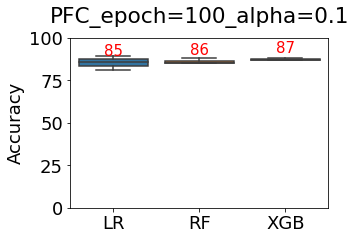

In [6]:
model_weight_list = run_ml(processed_emb_df, emb_name = emb_name, max_iter = 1000, print_accuracy = True)

# Getting the feature importances and the dimensions that make up 50% of feature importances

### Docker Machine learning & critical gene identifier

In [7]:
top_dim = plot_feature_importances(model_weight_list, top_n_coef = 0.5, print_num_dim = False, plot_heatmap = False, return_top_dim = True)

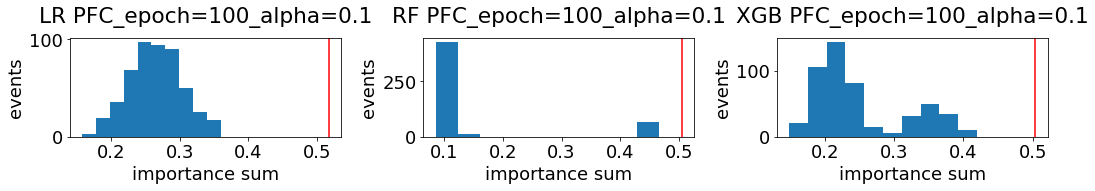

In [8]:
plot_random_feature_importance(model_weight_list, top_dim, emb_name)

## Determine jaccard similarity between the "important dimensions" for the repeats of the model

### Docker Machine learning & critical gene identifier

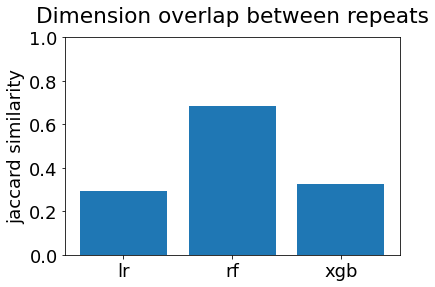

In [11]:
jaccard_average(top_dim, 'Dimension overlap between repeats')

# Identify critical genes from the parameters used (3 models, 3 repeats)

### Docker Machine learning & critical gene identifier

In [9]:
output_dir = prefix + '/Shared drives/NIAAA_ASSIST/Data/HDID_data/feature_extraction_derived/'

In [21]:
%%time
critical_gene_set = get_critical_gene_sets(processed_emb_df, top_dim, deseq = de_data)
critical_gene_df = get_critical_gene_df(critical_gene_set, emb_name, output_dir)

Wall time: 2min 40s


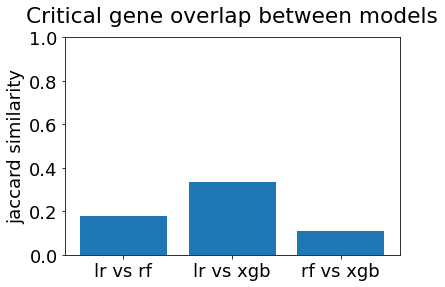

Wall time: 192 ms


In [13]:
%%time
intersect_genes = jaccard_critical_genes(critical_gene_df, 'Critical gene overlap between models')

## Plot correlation of sets of critical genes found in common in 3 models for each embedding

### Module DE/ Diagnostic Correlation (second one)

In [ ]:
# skipped
# expression_meta_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/eda_derived/expression_meta.csv', low_memory = False)
# gene_set_phenotype_corr(intersect_gene_list, embedding_names, expression_meta_df, 'intersect genes between 3 models')

## Plot number of nearby impact genes to the critical genes. 1 figure per embedding

### Docker Machine learning & critical gene identifier

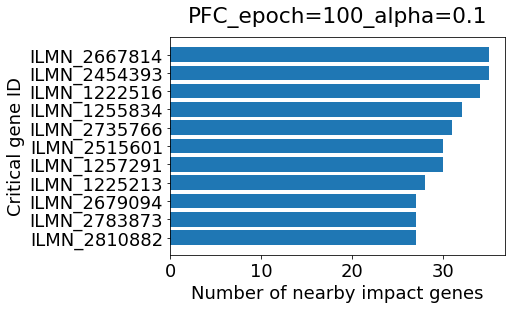

Wall time: 215 ms


In [23]:
%%time
critical_gene_set2 = plot_nearby_impact_num(critical_gene_df, emb_name)

## Plot each set of critical genes and their correlation with alcohol traits. Each gene set is from 1 embedding

### Module DE/ Diagnostic Correlation (second one)

In [ ]:
# skipped
# Plot correlation of top critical genes (with most nearby impact genes) for each embedding
# gene_set_phenotype_corr(critical_gene_sets2, embedding_names, expression_meta_df, 'top 10 genes')

## Ignore the codes below. These are to convert gene names from Illumina tags to gene symbols. They're not meant to be in any module. 

In [3]:
illumina_manifest = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/HDID_data/mousewg-6_v2_0_r3_11278593_a_txt.zip',
                               compression='zip', sep = '\t', skiprows=8, low_memory = False)

In [4]:
illumina_dict = pd.Series(illumina_manifest['Symbol'].values , index = illumina_manifest['Probe_Id']).to_dict()

In [12]:
critical_gene_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/HDID_data/feature_extraction_derived/PFC_epoch=100_alpha=0.1_critical_gene_df.csv')

In [6]:
critical_gene_df.head()

,gene,LR_repeat1,LR_repeat2,LR_repeat3,RF_repeat1,RF_repeat2,RF_repeat3,XGB_repeat1,XGB_repeat2,XGB_repeat3,near_impact_cnt
0,ILMN_2454393,4.0,2.0,6.0,2.0,4.0,4.0,4.0,5.0,4.0,35.0
1,ILMN_2667814,2.0,4.0,3.0,5.0,5.0,5.0,5.0,4.0,2.0,35.0
2,ILMN_1222516,2.0,5.0,2.0,6.0,3.0,5.0,6.0,3.0,2.0,34.0
3,ILMN_1255834,3.0,2.0,3.0,2.0,3.0,5.0,4.0,6.0,4.0,32.0
4,ILMN_2735766,2.0,4.0,2.0,6.0,3.0,5.0,2.0,4.0,3.0,31.0


In [7]:
converted_critical_gene_df = critical_gene_df.copy()
converted_critical_gene_df['gene'] = converted_critical_gene_df['gene'].map(illumina_dict)
# converted_critical_gene_df = converted_critical_gene_df[~converted_critical_gene_df['gene'].isna()]

Removing existing folder: output
Created folder output


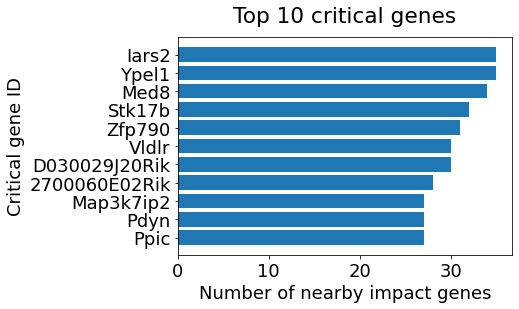

In [8]:
gene_set = plot_nearby_impact_num(converted_critical_gene_df, 'Top 10 critical genes')